In [224]:
import pandas as pd
import numpy as np
import os
import docx2txt
import docx
import re

In [140]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
import re
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


----
----
# Data Cleaning for MPC speech

In [156]:
MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')


We could see that 'Normal' style words refer to refference and labels which is not what we what 
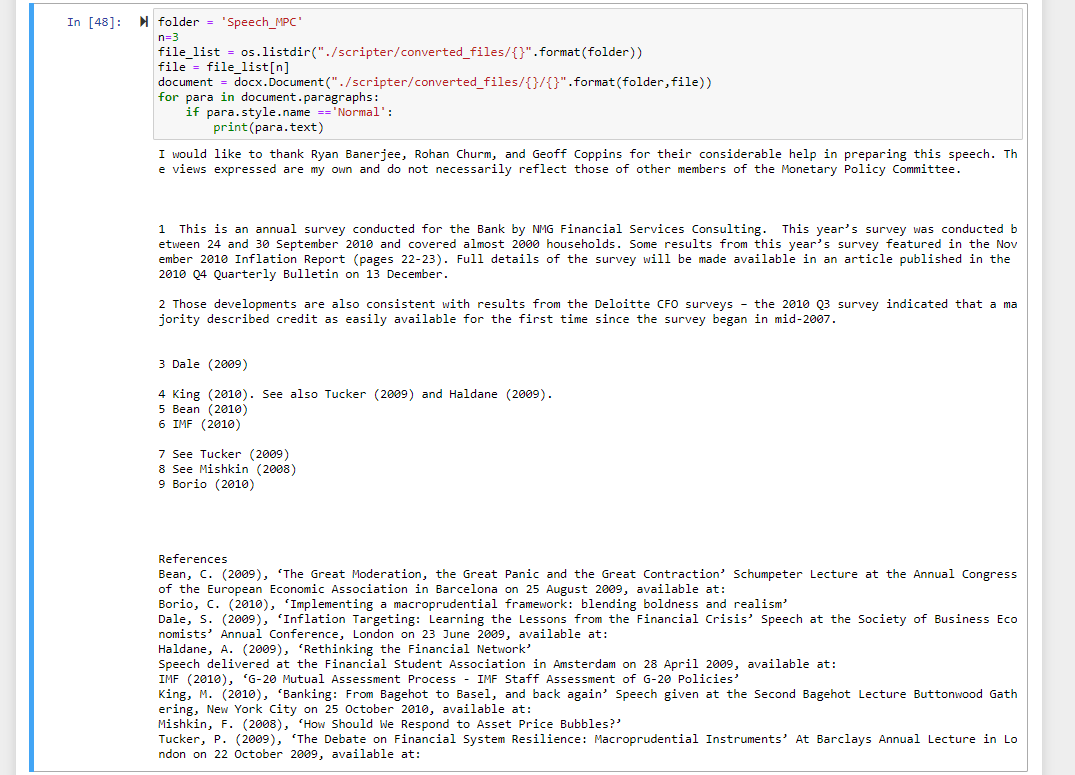

In [336]:
def print_doc_list(doc_list):
    for i in doc_list:
        print(i)
        print('')
        print('')
    return None

def check_If_reference(string):
    for year in range(2020,1950,-1):
        if '[{}]'.format(year) in string or '({})'.format(year) in string or '{}'.format(year) in string:
            if '“' in string or '‘' in string or "'" in string or 'pp.' in string or '"' in string:
                return True
    return False
 
def debug_print(document):
    for para in document.paragraphs:
        if para.style.name !='Normal':
            print(para.style.name)
            print(para.text)
    return None

def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech

In [449]:
MPC_speech.loc[:,'document_string'] = ''
folder = 'Speech_MPC'
file_list = os.listdir("./scripter/converted_files/{}".format(folder))
for n,file in enumerate(file_list):
    print('\r current file: {}/{}'.format(n,len(file_list)),end='')
    file =file.replace('~$','[D').replace('[Disk','‘Risk')
    document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
    Document_list = []   # each element represent one heading (section)
    paragraph_list = ''  # each element represent one paragraph in each section
    if_record = False
    Set_start = True
    
    if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
        for para in document.paragraphs:
            if para.style.name !='Normal':
                if 'Heading' in para.style.name:
                    if 'reference' in para.text.lower():
                        if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                        paragraph_list = ''
                        if_record = False
                    elif 'chart' in para.text.lower() or 'tabel' in para.text.lower() or 'figure' in para.text.lower():
                        pass
                    else:
                        if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                        paragraph_list = ''  # each element represent one paragraph in each section
                        if_record = True      # skip the element in the first page
                elif para.style.name == 'List Paragraph' and if_record == False:
                    paragraph_list = re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
                    if_record = True
                elif len(para.text.split())>=15 and if_record == True and not check_If_reference(para.text):
                    paragraph_list = paragraph_list + ' ###newsubpoint### '+ re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
                elif para.style.name == 'Body Text' and len(para.text)==0:
                    empty_bodytext_count+=1
                else:
                    pass

            if empty_bodytext_count>=15 and Set_start == True: # a force start if there has been enough empty empty new rows
                if_record = True
                Set_start = False
        Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', paragraph_list.replace('\uf0be','').replace('\t','')))    
    else:
        for para in document.paragraphs:
            if para.style.name !='Normal' and para.text.count(' ')<=2:
                if 'appendix' in para.text.lower() or 'reference' in para.text.lower():
                    break
            if para.style.name !='Normal' and len(para.text.split())>=15 and not check_If_reference(para.text):
                Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))) 
    Document_list = [ i for i in Document_list if len(i)>=1]
    if len(Document_list) == 1:
        Document_list = [i for i in Document_list[0].split(' ###newsubpoint### ') if i!='']
    else:
        Document_list = [i.replace(' ###newsubpoint### ',' ') for i in Document_list]
    Word_set = (' ###newline### ').join(Document_list)
    MPC_speech.loc[MPC_speech['title']==file[:-5],'document_string'] = Word_set
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()



 current file: 759/760

In [451]:
file = 'Acceptance remarks on receiving the International Financial Law Reviews Regulatory Contribution Award.docx'
document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
debug_print(document)

Heading 1
ACCEPTANCE REMARKS BY PAUL TUCKER ON RECEIVING THE INTERNATIONAL FINANCIAL LAW REVIEW’S REGULATORY CONTRIBUTION AWARD,
Body Text
(Collected on Paul Tucker’s behalf by Svein Andresen) Thank you very much to the IFLR.
Body Text
The greatest problem in international finance is Too Big To Fail. So long as it lies uncured, banking cannot assume its proper role at the heart of a market economy. Fortunately, a group of people – private sector as well as official sector – are determined to make distressed banks and dealers resolvable without taxpayer solvency support. That is what G20 Leaders have told us to do. Many people in this room are helping us get there. It will embarrass him to have to read this out but, through his role at the centre of the Financial Stability Board, Svein has been heroic in these efforts, and it is right that he collects this evening’s award. Eva Huepkes of FSB and Peter Brierley of the Bank of England also share the credit. But, truly, it is an endeavour 

In [448]:
document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
Document_list = []   # each element represent one heading (section)
paragraph_list = ''  # each element represent one paragraph in each section
if_record = False
Set_start = True
if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
    for para in document.paragraphs:
        if para.style.name !='Normal':
            if 'Heading' in para.style.name:
                if 'reference' in para.text.lower():
                    if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                    paragraph_list = ''
                    if_record = False
                elif 'chart' in para.text.lower() or 'tabel' in para.text.lower() or 'figure' in para.text.lower():
                    pass
                else:
                    if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                    paragraph_list = ''  # each element represent one paragraph in each section
                    if_record = True      # skip the element in the first page
            elif para.style.name == 'List Paragraph' and if_record == False:
                paragraph_list = re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
                if_record = True
            elif len(para.text.split())>=15 and if_record == True and not check_If_reference(para.text):
                paragraph_list = paragraph_list + ' ###newsubpoint### '+ re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
            elif para.style.name == 'Body Text' and len(para.text)==0:
                empty_bodytext_count+=1
            else:
                pass

        if empty_bodytext_count>=15 and Set_start == True: # a force start if there has been enough empty empty new rows
            if_record = True
            Set_start = False
    Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', paragraph_list.replace('\uf0be','').replace('\t','')))    
else:
    for para in document.paragraphs:
        if para.style.name !='Normal' and para.text.count(' ')<=2:
            if 'appendix' in para.text.lower() or 'reference' in para.text.lower():
                break
        if para.style.name !='Normal' and len(para.text.split())>=15 and not check_If_reference(para.text):
            Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))) 
Document_list = [ i for i in Document_list if len(i)>=1]
if len(Document_list) == 1:
    Document_list = [i for i in Document_list[0].split(' ###newsubpoint### ') if i!='']
else:
    Document_list = [i.replace(' ###newsubpoint### ',' ') for i in Document_list]
Word_set = (' ###newline### ').join(Document_list)
MPC_speech.loc[MPC_speech['title']==file[:-5],'document_string'] = Word_set
text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
text_file.write(Word_set)
text_file.close()
Document_list

['It is almost exactly a year since Lehman Brothers collapsed, precipitating a near-fatal heart attack for the global financial system. And in its wake came an unprecedentedly sharp and synchronised contraction in global economic activity, from which we are only just starting to emerge. In part, that stabilisation reflects the intensity of the countervailing policy actions by governments and central banks around the world.',
 'Injections of capital, funding guarantees, ring-fencing of toxic assets and abundant liquidity support have helped to return the banking system towards normality, though the process of balance-sheet repair still has some way to go. And substantial increases in fiscal deficits and aggressively expansionary monetary policies have helped to arrest the fall in spending, output and employment.',
 'For its part, the Bank of England s Monetary Policy Committee not only cut Bank Rate from 5% in September last year to just 0.5% in February, but also embarked on a programm

In [ ]:
MPC_speech = load_up_from_cleaned_speech()

In [410]:
MPC_speech.tag.unique()

array(['// Speech // Michael Saunders', '// Speech // Gertjan Vlieghe',
       '// Speech // Silvana Tenreyro', '// Speech // Mark Carney',
       '// Speech // Ben Broadbent', '// Speech // Jon Cunliffe',
       '// Speech // Jonathan Haskel', '// Speech // Dave Ramsden',
       '// Speech // Andy Haldane', '// Speech // Ian McCafferty',
       '// Speech // Kristin Forbes', '// Speech // Minouche Shafik',
       '// Speech // Martin Weale', '// Speech // David Miles',
       '// Speech', '// Speech // Monetary policy',
       '// Speech // Paul Fisher', '// Speech // Spencer Dale',
       '// Speech // Charles Bean', '// Speech // Paul Tucker',
       '// Speech // Mervyn King', '// Speech // Adam Posen',
       '// Speech // Speech', '// Speech // Andrew Sentance',
       '// Speech // Kate Barker', '// Speech // Timothy Besley',
       '// Speech // David Blanchflower', '// Speech // John Gieve',
       '// Speech // Rachel Lomax', '// Speech // Stephen Nickell',
       '// Speech 

----
----
# Data Cleaning for MPC minutes

In [452]:
MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')

In [458]:
folder ='Minutes_MPC'
file = 'Monetary Policy Summary and minutes - September 2017_1st.docx'
document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))

In [459]:
debug_print(document)

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text

Body Text
These are the minutes of the Monetary Policy Committee meeting ending on 13 September 2017. They are available at 
Body Text
The Bank of England Act 1998 gives the Bank of England operational responsibility for setting monetary policy to meet the Government’s inflation target. Operational decisions are taken by the Bank’s Monetary Policy Committee. The minutes of the Committee meeting ending on 1 November will be published on 2 November 2017.
Heading 1
Monetary Policy Summary, September 2017
Body Text

Body Text
The Bank of England’s Monetary Policy Committee (MPC) sets monetary policy to meet the 2% inflation target, and in a way that helps to sustain growth and employment. At its meeting ending on 13 September 2017, the MPC v

In [462]:

Document_list = []   # each element represent one heading (section)
paragraph_list = ''  # each element represent one paragraph in each section
if_record = False
Set_start = True
if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
    for para in document.paragraphs:
        if para.style.name !='Normal':
            if 'Heading' in para.style.name:
                if 'reference' in para.text.lower():
                    if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                    paragraph_list = ''
                    if_record = False
                elif 'chart' in para.text.lower() or 'tabel' in para.text.lower() or 'figure' in para.text.lower():
                    pass
                else:
                    if len(paragraph_list)>=10: Document_list.append(paragraph_list)
                    paragraph_list = ''  # each element represent one paragraph in each section
                    if_record = True      # skip the element in the first page
            elif para.style.name == 'List Paragraph' and if_record == False:
                paragraph_list = re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
                if_record = True
            elif len(para.text.split())>=15 and if_record == True and not check_If_reference(para.text):
                paragraph_list = paragraph_list + ' ###newsubpoint### '+ re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))
            elif para.style.name == 'Body Text' and len(para.text)==0:
                empty_bodytext_count+=1
            else:
                pass

        if empty_bodytext_count>=15 and Set_start == True: # a force start if there has been enough empty empty new rows
            if_record = True
            Set_start = False
    Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', paragraph_list.replace('\uf0be','').replace('\t','')))    
else:
    for para in document.paragraphs:
        if para.style.name !='Normal' and para.text.count(' ')<=2:
            if 'appendix' in para.text.lower() or 'reference' in para.text.lower():
                break
        if para.style.name !='Normal' and len(para.text.split())>=15 and not check_If_reference(para.text):
            Document_list.append(re.sub(r'[^\x00-\x7F]+',' ', para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))) 
Document_list = [ i for i in Document_list if len(i)>=1]
if len(Document_list) == 1:
    Document_list = [i for i in Document_list[0].split(' ###newsubpoint### ') if i!='']
else:
    Document_list = [i.replace(' ###newsubpoint### ',' ') for i in Document_list]
Word_set = (' ###newline### ').join(Document_list)

text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
text_file.write(Word_set)
text_file.close()
print_doc_list(Document_list)

 These are the minutes of the Monetary Policy Committee meeting ending on 13 September 2017. They are available at  The Bank of England Act 1998 gives the Bank of England operational responsibility for setting monetary policy to meet the Government s inflation target. Operational decisions are taken by the Bank s Monetary Policy Committee. The minutes of the Committee meeting ending on 1 November will be published on 2 November 2017.


 The Bank of England s Monetary Policy Committee (MPC) sets monetary policy to meet the 2% inflation target, and in a way that helps to sustain growth and employment. At its meeting ending on 13 September 2017, the MPC voted by a majority of 7-2 to maintain Bank Rate at 0.25%. The Committee voted unanimously to maintain the stock of sterling non-financial investment-grade corporate bond purchases, financed by the issuance of central bank reserves, at  10 billion.  The Committee voted unanimously to maintain the stock of UK government bond purchases, fina